# NR Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import sys
import random as rd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as tud
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import CustomDataset as cd

### Loading Data

First, I'm going to try to distinguish between Carbon 130keV and Flourine 170keV.

In [8]:
C130_dat, F170_dat = np.load('data/C_130keV_10000.npy'), np.load('data/F_170keV_10000.npy')

In [9]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append(0)
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append(1)
    Fsum.append(np.sum(F170_dat[i]))


Accuracy Possible with Cut of 2096 on Total Intensity: 93.67%


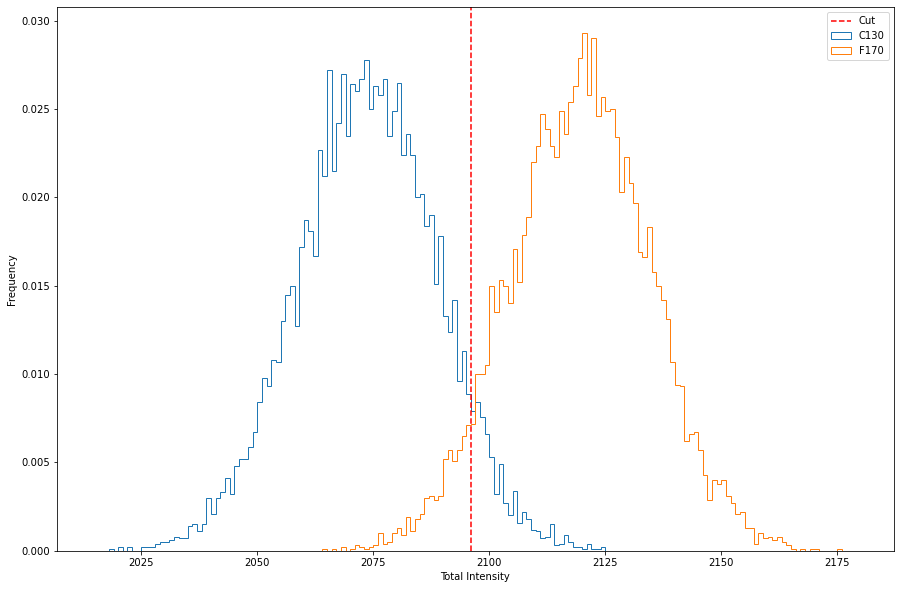

In [10]:
cut = 2096
Cless, Fgrt = [],[]
for i in range(len(Fsum)):
    if Fsum[i] > cut:
        Fgrt.append(Fsum[i])
    if Csum[i] <= cut:
        Cless.append(Csum[i])

plt.figure(figsize=(15,10))
plt.hist(Csum, density=True, histtype='step', bins=np.arange(2015,2180,1), label='C130')  # density=False would make counts
plt.hist(Fsum, density=True, histtype='step', bins=np.arange(2015,2180,1), label='F170')
plt.axvline(cut, c='r', ls='--', label='Cut')
plt.ylabel('Frequency')
plt.xlabel('Total Intensity')
plt.legend()
plt.savefig('intensity_hist.png')

Acc = (len(Fgrt)+len(Cless))/(len(Fsum)+len(Csum))*100
print('\nAccuracy Possible with Cut of {} on Total Intensity: {}%'.format(cut,Acc))

In [11]:
np.random.seed(10) #fixes random seed to 10 for reproducible results
p = np.random.permutation(len(data)) #performs random permutation to get shuffled indices
data = np.array(data)[p] #applies shuffled indices to X data
labels = np.array(labels)[p] #applies shuffled indices to y data

In [12]:
#Reducing data for testing model stability

In [13]:
# red_size = 3000
# data = data[:red_size]
# labels = labels[:red_size]

In [14]:
data.shape

(20000, 97, 97)

In [15]:
np.mean(data)

0.2227727494951642

In [16]:
# data_norm = data/np.max(data)
data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)
data_norm[data_norm!=data_norm]=0

/tmp/ipykernel_15604/2423433199.py:2: RuntimeWarning: invalid value encountered in true_divide
  data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)


In [17]:
BATCH_SIZE=100

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, labels, test_size=0.3, random_state=42)

xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
print(ytrain_tensor.shape)

xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
print(ytest_tensor.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_tensor.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_tensor.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([14000, 1, 97, 97])
torch.Size([14000])
torch.Size([6000, 1, 97, 97])
torch.Size([6000])


In [19]:
# for i, (images, labels) in enumerate(test_loader):
# #     print(images[0])
# #     plt.matshow(images[i].squeeze(0))
#     print(labels)
#     print(len(labels[labels==0]))
#     print(len(labels[labels==1]))

In [20]:
# for i, (images, labels) in enumerate(test_loader):
#     print(labels)
#     break

In [21]:
# Model


# class Model1(nn.Module):
#     def __init__(self):
#         super(Model1, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
#         self.d1 = nn.Linear(95 * 95 * 32, 128)
#         self.d2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)

#         x = x.flatten(start_dim = 1)

#         x = self.d1(x)
#         x = F.relu(x)

#         logits = self.d2(x)
#         out = F.softmax(logits, dim=1)
#         return out


# class Model2(nn.Module):
#     def __init__(self):
#         super(Model2, self).__init__()

#         self.d1 = nn.Linear(97 * 97, 1024)
#         self.d2 = nn.Linear(1024, 1024)
#         self.d3 = nn.Linear(1024, 2)

#     def forward(self, x):

#         x = x.flatten(start_dim = 1)

#         x = self.d1(x)
#         x = F.relu(x)

#         x = self.d2(x)
#         x = F.relu(x)

#         logits = self.d3(x)

#         out = F.softmax(logits, dim=1)

#         return out


class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        self.d1 = nn.Linear(97 * 97, 2)

    def forward(self, x):

        x = x.flatten(start_dim = 1)

        logits = self.d1(x)

        out = F.softmax(logits, dim=1)


        return out


In [22]:
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            
        self.fc_layers = nn.Sequential(
            nn.Linear(97*97,1),
            nn.ELU(),
            nn.Flatten(0,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc_layers(x)
        return x

In [23]:
# Accuracy

def get_accuracy(logit, target, BATCH_SIZE):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/BATCH_SIZE
    return accuracy.item()

In [24]:
# Training set up

learning_rate = 0.01
num_epochs = 500

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model2() 
model = model.to(device)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
# Training


for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):

        labels=labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))     
    
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    print('Test Accuracy: %.2f'%( test_acc/i))

Epoch: 0 | Loss: 0.7197 | Train Accuracy: 57.27
Test Accuracy: 60.54
Epoch: 1 | Loss: 0.7004 | Train Accuracy: 60.17
Test Accuracy: 60.46
Epoch: 2 | Loss: 0.6866 | Train Accuracy: 62.00
Test Accuracy: 60.17
Epoch: 3 | Loss: 0.6855 | Train Accuracy: 62.19
Test Accuracy: 59.64
Epoch: 4 | Loss: 0.6760 | Train Accuracy: 63.33
Test Accuracy: 59.95
Epoch: 5 | Loss: 0.6727 | Train Accuracy: 63.76
Test Accuracy: 60.69
Epoch: 6 | Loss: 0.6667 | Train Accuracy: 64.40
Test Accuracy: 61.66
Epoch: 7 | Loss: 0.6615 | Train Accuracy: 65.11
Test Accuracy: 61.08
Epoch: 8 | Loss: 0.6583 | Train Accuracy: 65.42
Test Accuracy: 61.20
Epoch: 9 | Loss: 0.6567 | Train Accuracy: 65.50
Test Accuracy: 60.54
Epoch: 10 | Loss: 0.6554 | Train Accuracy: 65.77
Test Accuracy: 61.29
Epoch: 11 | Loss: 0.6492 | Train Accuracy: 66.43
Test Accuracy: 60.98
Epoch: 12 | Loss: 0.6481 | Train Accuracy: 66.51
Test Accuracy: 61.51
Epoch: 13 | Loss: 0.6411 | Train Accuracy: 67.35
Test Accuracy: 61.08
Epoch: 14 | Loss: 0.6421 | Tra

In [26]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 88.68


In [27]:
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
pre_cor = (torch.max(outputs, 1)[1].view(labels.size()).data == labels.data)
corrects = (torch.max(outputs, 1)[1].view(labels.size()).data == labels.data).sum()
accuracy = 100.0 * corrects/BATCH_SIZE

In [30]:
print(labels[0])

tensor(0., device='cuda:0')


In [22]:
pre_cor

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')

In [23]:
corrects

tensor(89, device='cuda:0')

In [24]:
labels

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 1., 1., 0.], device='cuda:0')

For 500 epochs, learning rate 0.01:

In [26]:
num_train_ims = [1000,]
test_acc = [82]

## Amplified Data

In [156]:
C130_dat, F170_dat = np.load('amp_ims/C_130keV.npy'), np.load('amp_ims/F_170keV.npy')

In [157]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append(0)
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append(1)
    Fsum.append(np.sum(F170_dat[i]))

In [158]:
np.random.seed(10) #fixes random seed to 10 for reproducible results
p = np.random.permutation(len(data)) #performs random permutation to get shuffled indices
data = np.array(data)[p] #applies shuffled indices to X data
labels = np.array(labels)[p] #applies shuffled indices to y data

In [159]:
data.shape

(8000, 144, 144)

In [160]:
labels.shape

(8000,)

In [161]:
data.astype('float64')

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [162]:
# data_norm = data/np.max(data)
data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)
data_norm[data_norm!=data_norm]=0

/tmp/ipykernel_577/2423433199.py:2: RuntimeWarning: invalid value encountered in true_divide
  data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)


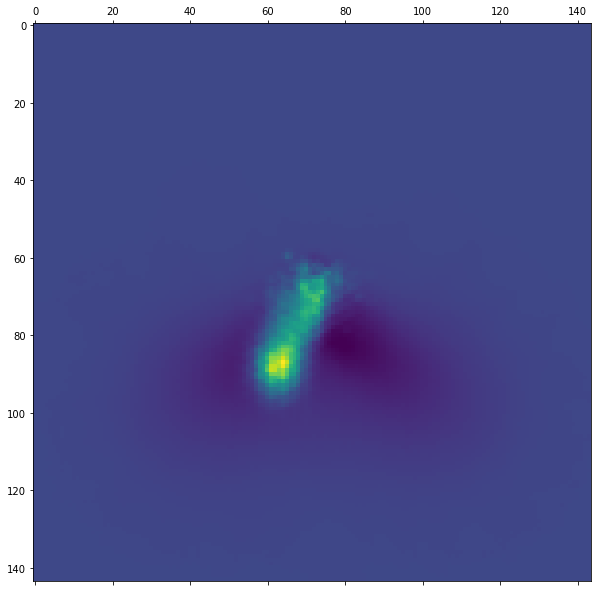

In [178]:
plt.figure(figsize=(10,10))
plt.matshow(data_norm[17],fignum=1)

In [164]:
BATCH_SIZE=100

In [165]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [166]:
X_train.astype('float64')


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [167]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=42)

xtrain_tensor = torch.from_numpy(np.array(X_train.astype('float64'))) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
print(ytrain_tensor.shape)

xtest_tensor = torch.from_numpy(np.array(X_test.astype('float64'))) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
print(ytest_tensor.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_tensor.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_tensor.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([4800, 1, 144, 144])
torch.Size([4800])
torch.Size([3200, 1, 144, 144])
torch.Size([3200])


In [168]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.d1 = nn.Linear(142 * 142 * 8, 128)
        self.d2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [169]:
def get_accuracy(logit, target, BATCH_SIZE):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/BATCH_SIZE
    return accuracy.item()

In [173]:
learning_rate = 0.000001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model3() 
model = model.to(device)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [174]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):

        labels=labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))     
    
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    print('Test Accuracy: %.2f'%( test_acc/i))

Epoch: 0 | Loss: 0.7019 | Train Accuracy: 63.89
Test Accuracy: 67.13
Epoch: 1 | Loss: 0.6537 | Train Accuracy: 68.72
Test Accuracy: 72.84
Epoch: 2 | Loss: 0.6445 | Train Accuracy: 69.55
Test Accuracy: 73.00
Epoch: 3 | Loss: 0.6056 | Train Accuracy: 73.51
Test Accuracy: 77.48
Epoch: 4 | Loss: 0.5823 | Train Accuracy: 75.87
Test Accuracy: 78.81
Epoch: 5 | Loss: 0.5774 | Train Accuracy: 76.32
Test Accuracy: 80.16
Epoch: 6 | Loss: 0.5798 | Train Accuracy: 76.11
Test Accuracy: 75.77
Epoch: 7 | Loss: 0.5907 | Train Accuracy: 75.00
Test Accuracy: 79.97
Epoch: 8 | Loss: 0.5763 | Train Accuracy: 76.43
Test Accuracy: 78.55
Epoch: 9 | Loss: 0.5576 | Train Accuracy: 78.34
Test Accuracy: 79.10


In [175]:
for i, (images, labels) in enumerate(train_loader):

        labels=labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)
        
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 144, 144])
torch.Size([100])


### Starting Again with Tensorflow

In [88]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [89]:
C130_dat, F170_dat = np.load('data_old/C_130keV_10000.npy'), np.load('data_old/F_170keV_10000.npy')

In [90]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))

In [91]:
data -= np.mean(data)
data/=np.std(data)

In [92]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

In [93]:
# train_data, train_labels = [],[]
# test_data, test_labels = [],[]
# Csum, Fsum = [],[]

# n_train = int(len(C130_dat) * 0.8)

# for i in range(n_train):
#     train_data.append(C130_dat[i])
#     train_labels.append([1,0])
#     Csum.append(np.sum(C130_dat[i]))

# for i in range(n_train):
#     train_data.append(F170_dat[i])
#     train_labels.append([0,1])
#     Fsum.append(np.sum(F170_dat[i]))

# for i in range(n_train, len(C130_dat)):
#     test_data.append(C130_dat[i])
#     test_labels.append([1,0])
#     Csum.append(np.sum(C130_dat[i]))

# for i in range(n_train, len(F170_dat)):
#     test_data.append(F170_dat[i])
#     test_labels.append([0,1])
#     Fsum.append(np.sum(F170_dat[i]))


# # Maximum values

# C130_max = np.amax(np.amax(C130_dat, axis=(1,2)))
# F170_max = np.amax(np.amax(F170_dat, axis=(1,2)))
# all_max = max(C130_max, F170_max)


# # Normalise to (0,1)

# train_data = np.array(train_data) / all_max
# train_labels = np.array(train_labels)
# test_data = np.array(test_data) / all_max
# test_labels = np.array(test_labels)

# # Shuffle Data

# train_data, train_labels = shuffle(train_data, train_labels)
# test_data, test_labels = shuffle(test_data, test_labels)

In [94]:
# tot_data=[]
# for i in range(len(train_data)):
#     tot_data.append(train_data[i])
# for i in range(len(test_data)):
#     tot_data.append(test_data[i])

In [95]:
# train_data -= np.mean(train_data)
# train_data/=np.std(train_data)

# test_data -= np.mean(test_data)
# test_data/=np.std(test_data)

In [96]:
np.mean(test_data)

2.8451436103516313e-07

In [97]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(train_labels))
print(np.shape(test_labels))

(14000, 97, 97)
(6000, 97, 97)
(14000, 2)
(6000, 2)


In [98]:
dat_sum = [np.sum(test_data[i]) for i in range(len(test_data))]

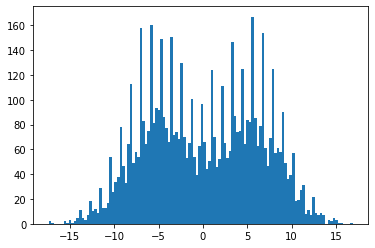

In [99]:
plt.hist(dat_sum,bins=120);

We have 10,000 1s and 10,000 0s.

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(1, kernel_size=(3,3), input_shape=(97,97,1), activation='relu', padding='same'),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

In [160]:
model.summary()

Model: "nr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 97, 97, 1)         10        
                                                                 
 flatten_19 (Flatten)        (None, 9409)              0         
                                                                 
 dense_23 (Dense)            (None, 1024)              9635840   
                                                                 
 dense_24 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 9,637,900
Trainable params: 9,637,900
Non-trainable params: 0
_________________________________________________________________


In [161]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)


In [162]:
#batching the datasets
batch_size = 34
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [163]:
#compiling and fitting the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
412/412 [==============================] - 9s 22ms/step - loss: 0.6893 - accuracy: 0.5321 - val_loss: 0.6868 - val_accuracy: 0.5463
Epoch 2/20
412/412 [==============================] - 9s 22ms/step - loss: 0.6710 - accuracy: 0.5834 - val_loss: 0.6833 - val_accuracy: 0.5668
Epoch 3/20
412/412 [==============================] - 9s 22ms/step - loss: 0.6517 - accuracy: 0.6165 - val_loss: 0.6846 - val_accuracy: 0.5730
Epoch 4/20
412/412 [==============================] - 9s 22ms/step - loss: 0.6303 - accuracy: 0.6419 - val_loss: 0.6898 - val_accuracy: 0.5760
Epoch 5/20
412/412 [==============================] - 9s 22ms/step - loss: 0.6047 - accuracy: 0.6695 - val_loss: 0.7005 - val_accuracy: 0.5785
Epoch 6/20
412/412 [==============================] - 9s 21ms/step - loss: 0.5702 - accuracy: 0.7025 - val_loss: 0.7194 - val_accuracy: 0.5778
Epoch 7/20
412/412 [==============================] - 9s 22ms/step - loss: 0.5230 - accuracy: 0.7426 - val_loss: 0.7559 - val_accuracy: 0.5745

KeyboardInterrupt: 

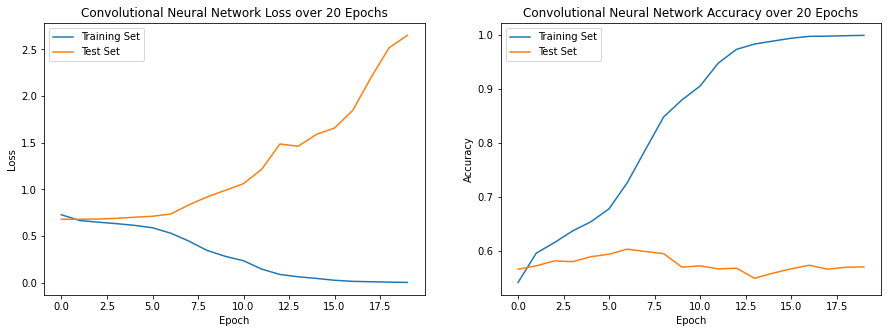

In [273]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss']),ax1.plot(history.history['val_loss'])
ax1.set_title('Convolutional Neural Network Loss over 20 Epochs')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy']),ax2.plot(history.history['val_accuracy'])
ax2.set_title('Convolutional Neural Network Accuracy over 20 Epochs')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');

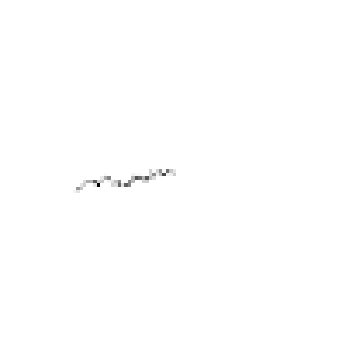

In [274]:
image = train_data[43]

#initial plotting of chosen image
plt.figure(figsize=(6, 10))
plt.imshow(image,cmap='Greys')
plt.axis('off')
plt.show()

In [275]:
from tensorflow.keras.models import Model

#Model and model are different
#getting model inputs, layer names, outputs for visualisation
inputs = model.inputs
layer_names = [layer.name for layer in model.layers]
outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
#creating model for extracting features
model_features = Model(inputs=inputs, outputs=outputs)

In [276]:
#re-shaping image and passing through new model to output features
input = image.reshape((1,) + image.shape)
features = model_features.predict(input)

In [283]:
conv_features = features[0]

IndexError: index 1 is out of bounds for axis 2 with size 1

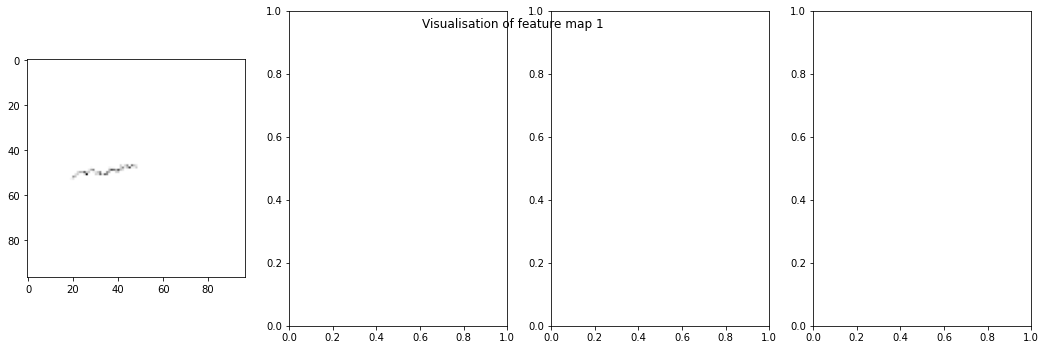

In [284]:
#plotting features from convolutional layers, along with layer names
fig, axs = plt.subplots(1,4, figsize=(18,5))
fig.subplots_adjust(top=1)
fig.suptitle('Visualisation of feature map 1')
axs[0].imshow(image, cmap='Greys',label='input')
for i in range(len(conv_features)):
    feature_map = conv_features[i]
    axs[i+1].imshow(feature_map[0, ..., 1],cmap='Greys')
    axs[i+1].set_title(layer_names[i]);

In [285]:
np.set_printoptions(threshold=sys.maxsize)
print(model.layers[0].weights)
print(model.layers[0].bias.numpy())
print(model.layers[0].bias_initializer)

[<tf.Variable 'conv2d_15/kernel:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
array([[[[-0.34715784]],

        [[ 0.32376805]],

        [[ 0.60402894]]],


       [[[-0.18727666]],

        [[-0.07132195]],

        [[-0.51992166]]],


       [[[-0.4930481 ]],

        [[ 0.45596677]],

        [[-0.5037943 ]]]], dtype=float32)>, <tf.Variable 'conv2d_15/bias:0' shape=(1,) dtype=float32, numpy=array([-0.03143696], dtype=float32)>]
[-0.03143696]


### Linear Model

In [180]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)


In [181]:
#batching the datasets
batch_size = 34
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [182]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def lin_model():
    lin_model = Sequential([
        Flatten(input_shape=(97,97,1)),
        Dense(2, activation='softmax')
    ], name='lin_model')
    return lin_model

model = lin_model()

In [183]:
model.summary()

Model: "lin_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 9409)              0         
                                                                 
 dense_28 (Dense)            (None, 2)                 18820     
                                                                 
Total params: 18,820
Trainable params: 18,820
Non-trainable params: 0
_________________________________________________________________


In [184]:
#compiling and fitting the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=250, validation_data=test_dataset)

Epoch 1/250
412/412 [==============================] - 2s 4ms/step - loss: 0.7999 - accuracy: 0.5442 - val_loss: 0.8075 - val_accuracy: 0.5472
Epoch 2/250
412/412 [==============================] - 2s 4ms/step - loss: 0.7269 - accuracy: 0.5826 - val_loss: 0.8015 - val_accuracy: 0.5615
Epoch 3/250
412/412 [==============================] - 2s 4ms/step - loss: 0.7023 - accuracy: 0.5993 - val_loss: 0.7921 - val_accuracy: 0.5727
Epoch 4/250
412/412 [==============================] - 2s 4ms/step - loss: 0.6822 - accuracy: 0.6161 - val_loss: 0.7817 - val_accuracy: 0.5858
Epoch 5/250
412/412 [==============================] - 2s 4ms/step - loss: 0.6640 - accuracy: 0.6280 - val_loss: 0.7707 - val_accuracy: 0.5973
Epoch 6/250
412/412 [==============================] - 2s 4ms/step - loss: 0.6471 - accuracy: 0.6401 - val_loss: 0.7592 - val_accuracy: 0.6070
Epoch 7/250
412/412 [==============================] - 2s 4ms/step - loss: 0.6313 - accuracy: 0.6500 - val_loss: 0.7477 - val_accuracy: 0.6167

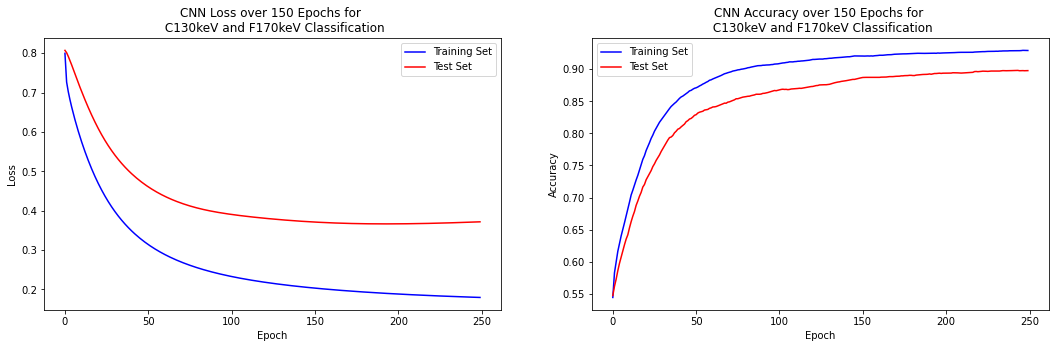

In [186]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.plot(history.history['loss'],c='b'),ax1.plot(history.history['val_loss'],c='r')
ax1.set_title('CNN Loss over 150 Epochs for \n C130keV and F170keV Classification')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy'],c='b'),ax2.plot(history.history['val_accuracy'],c='r')
ax2.set_title('CNN Accuracy over 150 Epochs for \n C130keV and F170keV Classification')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');

In [326]:
print(model.layers[1].weights)
print(model.layers[1].bias.numpy())
print(model.layers[1].bias_initializer)

[<tf.Variable 'dense_33/kernel:0' shape=(9409, 2) dtype=float32, numpy=
array([[-1.79776549e-01,  1.84193313e-01],
       [-1.84511393e-01,  1.45599097e-01],
       [-1.42560065e-01,  1.68340653e-01],
       [-1.68290526e-01,  1.39704376e-01],
       [-1.82305217e-01,  1.71332240e-01],
       [-1.55663103e-01,  1.41448110e-01],
       [-1.55820042e-01,  1.87860668e-01],
       [-1.46092355e-01,  1.61511302e-01],
       [-1.55649722e-01,  1.83158696e-01],
       [-1.69681162e-01,  1.44463003e-01],
       [-1.46067262e-01,  1.62748247e-01],
       [-1.88347518e-01,  1.87644243e-01],
       [-1.85524076e-01,  1.71786606e-01],
       [-1.84875816e-01,  1.67520911e-01],
       [-1.47368670e-01,  1.48086011e-01],
       [-1.77283585e-01,  1.80742204e-01],
       [-1.84224695e-01,  1.41484678e-01],
       [-1.65652305e-01,  1.70751482e-01],
       [-1.89948648e-01,  1.63487643e-01],
       [-1.66598052e-01,  1.86328322e-01],
       [-1.71033412e-01,  1.78890973e-01],
       [-1.76237255e-01, 

In [327]:
weights_arr = model.layers[1].weights[0]

In [328]:
weights_array = weights_arr.numpy()

In [329]:
weights_array.shape

(9409, 2)

In [330]:
print(np.max(weights_array[0]))
print(np.min(weights_array[0]))
print(np.mean(weights_array[0]))
print(np.std(weights_array[0]))

0.18419331
-0.17977655
0.002208382
0.18198493


Low standard deviation, as we would expect.

## Setting Intensities as Equal

In [192]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [193]:
C130_dat, F170_dat = np.load('data_old/C_130keV_10000.npy'), np.load('data_old/F_170keV_10000.npy')

In [194]:
C130_dat -= np.mean(C130_dat) # the -= means can be read as x = x- np.mean(x)
C130_dat/=np.std(C130_dat)

F170_dat -= np.mean(F170_dat) # the -= means can be read as x = x- np.mean(x)
F170_dat/=np.std(F170_dat)

In [195]:
train_data, train_labels = [],[]
test_data, test_labels = [],[]
Csum, Fsum = [],[]

n_train = int(len(C130_dat) * 0.8)

for i in range(n_train):
    train_data.append(C130_dat[i])
    train_labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(n_train):
    train_data.append(F170_dat[i])
    train_labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))

for i in range(n_train, len(C130_dat)):
    test_data.append(C130_dat[i])
    test_labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(n_train, len(F170_dat)):
    test_data.append(F170_dat[i])
    test_labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))


# Maximum values

C130_max = np.amax(np.amax(C130_dat, axis=(1,2)))
F170_max = np.amax(np.amax(F170_dat, axis=(1,2)))
all_max = max(C130_max, F170_max)


# Normalise to (0,1)

train_data = np.array(train_data) / all_max
train_labels = np.array(train_labels)
test_data = np.array(test_data) / all_max
test_labels = np.array(test_labels)

# Shuffle Data

train_data, train_labels = shuffle(train_data, train_labels)
test_data, test_labels = shuffle(test_data, test_labels)


Accuracy Possible with Cut of 0 on Total Intensity: 51.345%


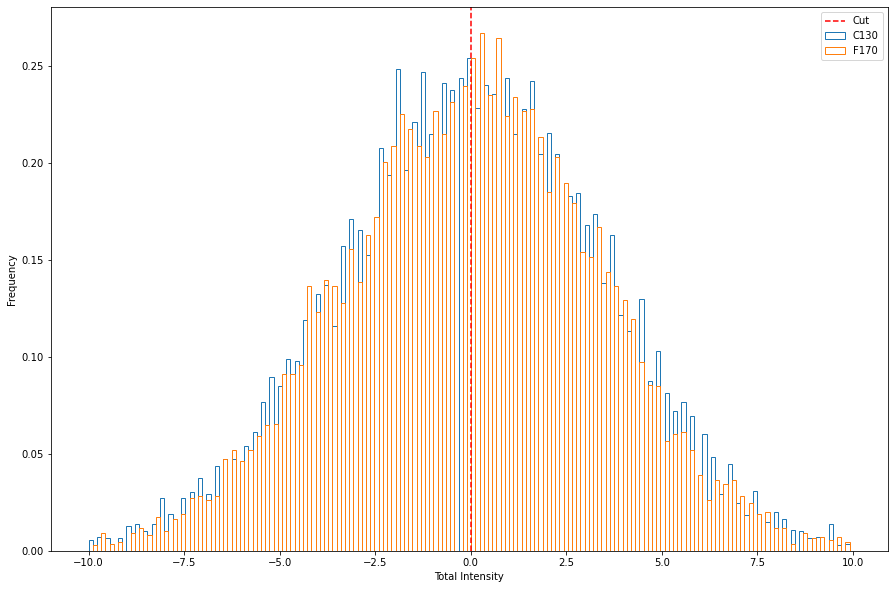

In [196]:
cut = 0
Cless, Fgrt = [],[]
for i in range(len(Fsum)):
    if Fsum[i] > cut:
        Fgrt.append(Fsum[i])
    if Csum[i] <= cut:
        Cless.append(Csum[i])

plt.figure(figsize=(15,10))
plt.hist(Csum, density=True, histtype='step', bins=np.arange(-10,10,0.11), label='C130')  # density=False would make counts
plt.hist(Fsum, density=True, histtype='step', bins=np.arange(-10,10,0.11), label='F170')
plt.axvline(cut, c='r', ls='--', label='Cut')
plt.ylabel('Frequency')
plt.xlabel('Total Intensity')
plt.legend()
plt.savefig('intensity_hist.png')

Acc = (len(Fgrt)+len(Cless))/(len(Fsum)+len(Csum))*100
print('\nAccuracy Possible with Cut of {} on Total Intensity: {}%'.format(cut,Acc))

angle
dE/dx
(Length and intensity)
probability of secondary recoil (different for different energies)


Before histogram of electrons at gem
clipping for flourine vs carbon - maybe why overfitting?


Explain what each node is - it's not that each node represents 'whether it's orange' - it represents some value and the combination of the values of all nodes means its an orange.

In [197]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


# def nr_model():
#     nr_model = Sequential([
#         Conv2D(8, kernel_size=(3,3), input_shape=(97,97,1)),
#         LeakyReLU(alpha=0.01),
#         Conv2D(8, kernel_size=(3,3)),
#         LeakyReLU(alpha=0.01),
#         Flatten(),
#         Dense(2, activation='softmax')
#     ], name='nr_model')
#     return nr_model


# model = nr_model()

In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(4, kernel_size=(3,3), input_shape=(97,97,1)),
        LeakyReLU(alpha=0.01),
        Conv2D(8, kernel_size=(3,3)),
        LeakyReLU(alpha=0.01),
        Flatten(),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

In [199]:
np.shape(test_labels)

(4000, 2)

In [200]:
np.shape(train_labels)

(16000, 2)

In [201]:
np.shape(train_data)

(16000, 97, 97)

In [202]:
model.summary()

Model: "nr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 95, 95, 4)         40        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 95, 95, 4)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 93, 93, 8)         296       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 93, 93, 8)         0         
                                                                 
 flatten_24 (Flatten)        (None, 69192)             0         
                                                                 
 dense_29 (Dense)            (None, 2)                 138386    
                                                                 
Total params: 138,722
Trainable params: 138,722
Non-traina

In [203]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)


In [204]:
#batching the datasets
batch_size = 50
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [205]:
#compiling and fitting the model
sgd = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=120, validation_data=test_dataset)

Epoch 1/120
320/320 [==============================] - 10s 30ms/step - loss: 0.6859 - accuracy: 0.5556 - val_loss: 0.6784 - val_accuracy: 0.5740
Epoch 2/120
320/320 [==============================] - 10s 30ms/step - loss: 0.6751 - accuracy: 0.5824 - val_loss: 0.6737 - val_accuracy: 0.5825
Epoch 3/120
320/320 [==============================] - 10s 31ms/step - loss: 0.6639 - accuracy: 0.6045 - val_loss: 0.6730 - val_accuracy: 0.5920
Epoch 4/120
320/320 [==============================] - 10s 31ms/step - loss: 0.6506 - accuracy: 0.6176 - val_loss: 0.6705 - val_accuracy: 0.5990
Epoch 5/120
320/320 [==============================] - 10s 31ms/step - loss: 0.6382 - accuracy: 0.6317 - val_loss: 0.6706 - val_accuracy: 0.6037
Epoch 6/120
320/320 [==============================] - 10s 31ms/step - loss: 0.6267 - accuracy: 0.6423 - val_loss: 0.6696 - val_accuracy: 0.5997
Epoch 7/120
320/320 [==============================] - 10s 31ms/step - loss: 0.6160 - accuracy: 0.6532 - val_loss: 0.6718 - val_ac

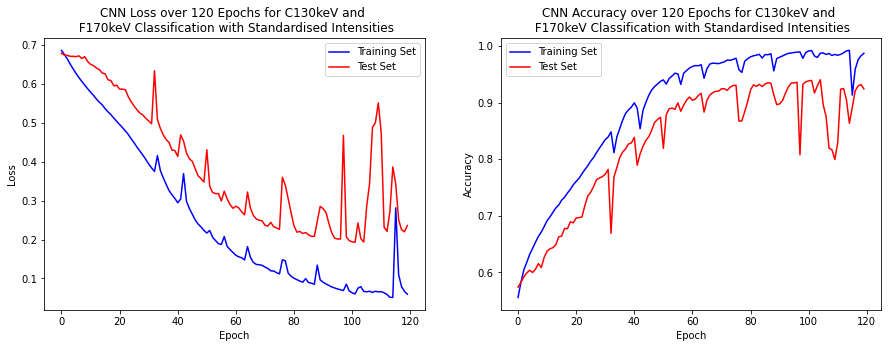

In [209]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss'],c='b'),ax1.plot(history.history['val_loss'],c='r')
ax1.set_title('CNN Loss over 120 Epochs for C130keV and \n F170keV Classification with Standardised Intensities')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy'],c='b'),ax2.plot(history.history['val_accuracy'],c='r')
ax2.set_title('CNN Accuracy over 120 Epochs for C130keV and \n F170keV Classification with Standardised Intensities')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');

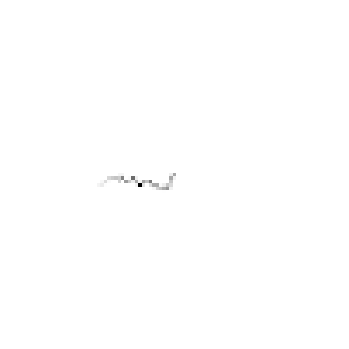

In [210]:
image = train_data[43]

#initial plotting of chosen image
plt.figure(figsize=(6, 10))
plt.imshow(image,cmap='Greys')
plt.axis('off')
plt.show()

In [211]:
from tensorflow.keras.models import Model

#Model and model are different
#getting model inputs, layer names, outputs for visualisation
inputs = model.inputs
layer_names = [layer.name for layer in model.layers]
outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
#creating model for extracting features
model_features = Model(inputs=inputs, outputs=outputs)

In [224]:
#testing model_features
model_features.inputs
model_features.outputs;

In [212]:
#re-shaping image and passing through new model to output features
input = image.reshape((1,) + image.shape)
features = model_features.predict(input)

In [225]:
#the length of features should match the number of layers
len(features)

6

In [226]:
#printing all layers from CNN
for layer_name, feature_map in zip(layer_names, features):
    print(f"The shape of the {layer_name} is: {feature_map.shape}")

The shape of the conv2d_18 is: (1, 95, 95, 4)
The shape of the leaky_re_lu is: (1, 95, 95, 4)
The shape of the conv2d_19 is: (1, 93, 93, 8)
The shape of the leaky_re_lu_1 is: (1, 93, 93, 8)
The shape of the flatten_24 is: (1, 69192)
The shape of the dense_29 is: (1, 2)


In [ ]:
#selecting features from convolutional layers
conv_features = features[0], features[2]

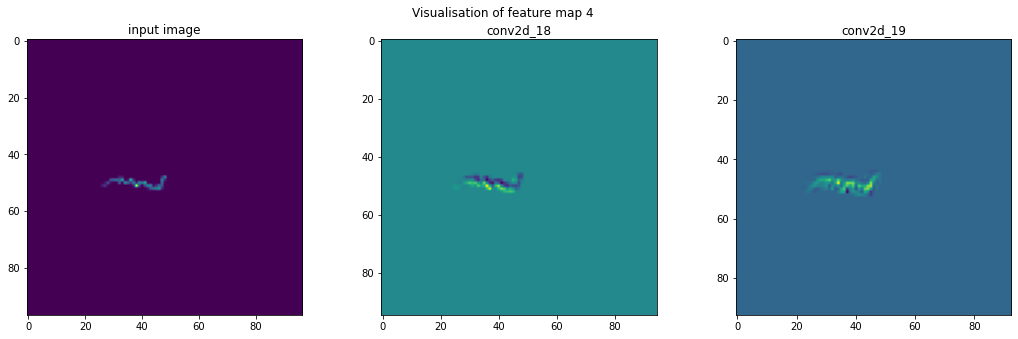

In [248]:
#plotting features from convolutional layers, along with layer names
fig, axs = plt.subplots(1,3, figsize=(18,5))
fig.subplots_adjust(top=0.89)
fig.suptitle('Visualisation of feature map 4')
axs[0].imshow(image)
axs[0].set_title('input image')
for i in range(len(conv_features)):
      feature_map = conv_features[i]
      axs[i+1].imshow(feature_map[0, ..., 3])
      axs[i+1].set_title(layer_names[i*2]);

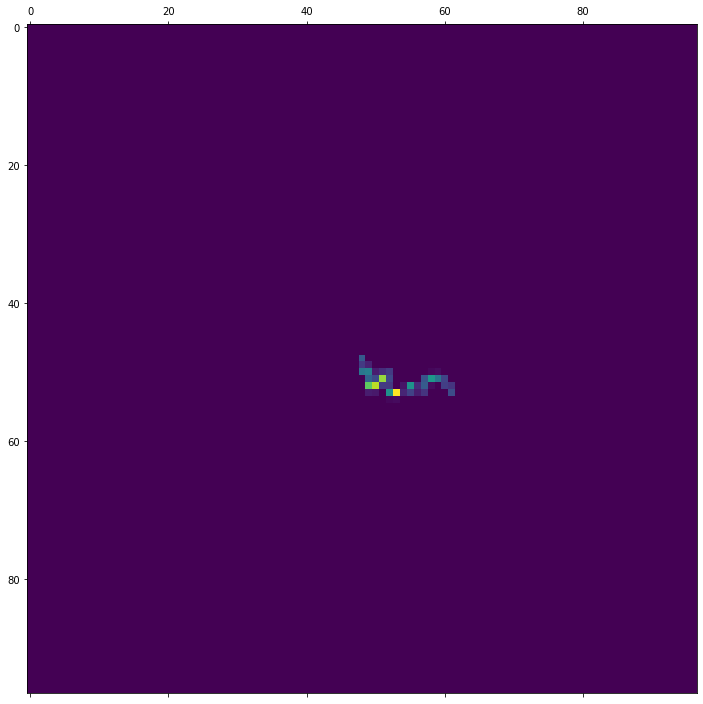

In [406]:
plt.figure(figsize=(12,12))
plt.matshow(F170_dat[135],fignum=1);

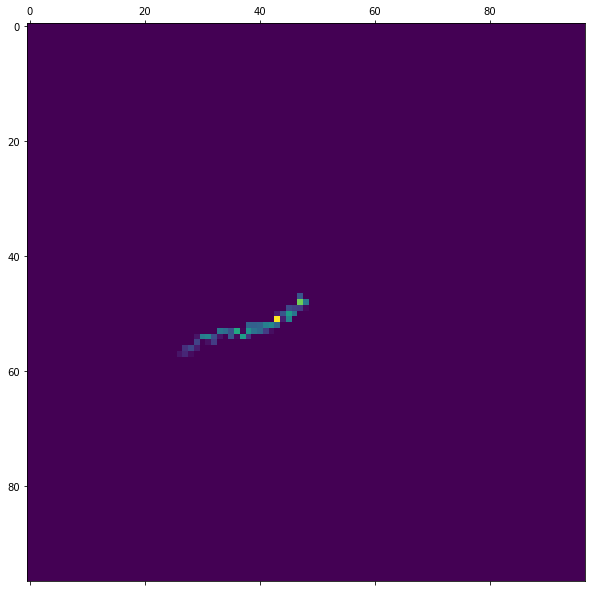

In [390]:
plt.figure(figsize=(10,10))
plt.matshow(F170_dat[17],fignum=1);

## Doing both same energy again

In [32]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [33]:
C170_dat, F170_dat = np.load('data_old/C_170keV.npy'), np.load('data_old/F_170keV.npy')

In [34]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C170_dat)):
    data.append(C170_dat[i])
    labels.append([1,0])
    Csum.append(np.sum(C170_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))

In [35]:
data -= np.mean(data)
data/=np.std(data)

In [36]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(2, kernel_size=(3,3), input_shape=(97,97,1), activation='relu'),
        Flatten(),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

In [44]:
model.summary()

Model: "nr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 95, 95, 2)         20        
                                                                 
 flatten_5 (Flatten)         (None, 18050)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 36102     
                                                                 
Total params: 36,122
Trainable params: 36,122
Non-trainable params: 0
_________________________________________________________________


In [45]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)


In [46]:
#batching the datasets
batch_size = 50
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [47]:
#compiling and fitting the model
sgd = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
140/140 [==============================] - 2s 15ms/step - loss: 0.6249 - accuracy: 0.6651 - val_loss: 0.5565 - val_accuracy: 0.7037
Epoch 2/20
140/140 [==============================] - 2s 14ms/step - loss: 0.4976 - accuracy: 0.7443 - val_loss: 0.5308 - val_accuracy: 0.7310
Epoch 3/20
140/140 [==============================] - 2s 14ms/step - loss: 0.3563 - accuracy: 0.8450 - val_loss: 0.2514 - val_accuracy: 0.9363
Epoch 4/20
140/140 [==============================] - 2s 14ms/step - loss: 0.1229 - accuracy: 0.9856 - val_loss: 0.0960 - val_accuracy: 0.9897
Epoch 5/20
140/140 [==============================] - 2s 14ms/step - loss: 0.0444 - accuracy: 0.9994 - val_loss: 0.0459 - val_accuracy: 0.9963
Epoch 6/20
140/140 [==============================] - 2s 14ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy: 0.9977
Epoch 7/20
140/140 [==============================] - 2s 14ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 0.9983

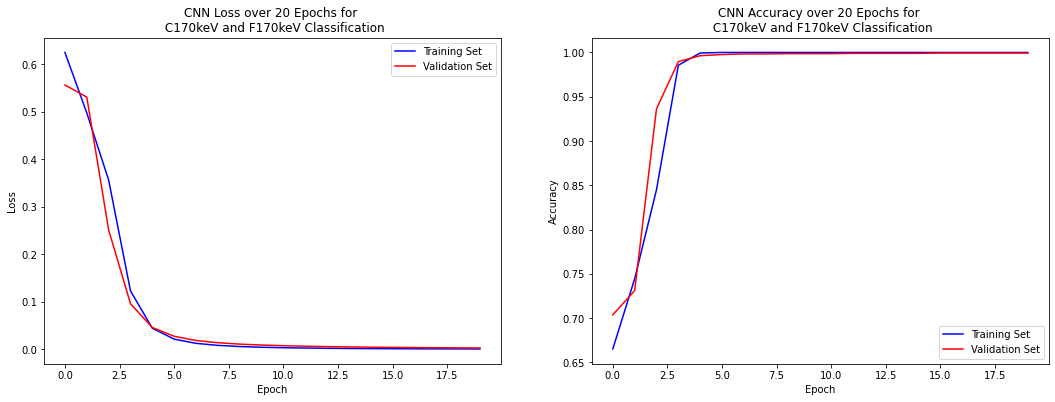

In [57]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
ax1.plot(history.history['loss'],c='b'),ax1.plot(history.history['val_loss'],c='r')
ax1.set_title('CNN Loss over 20 Epochs for \n C170keV and F170keV Classification')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Validation Set'], loc='best');
ax2.plot(history.history['accuracy'],c='b'),ax2.plot(history.history['val_accuracy'],c='r')
ax2.set_title('CNN Accuracy over 20 Epochs for \n C170keV and F170keV Classification')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Validation Set'], loc='best');

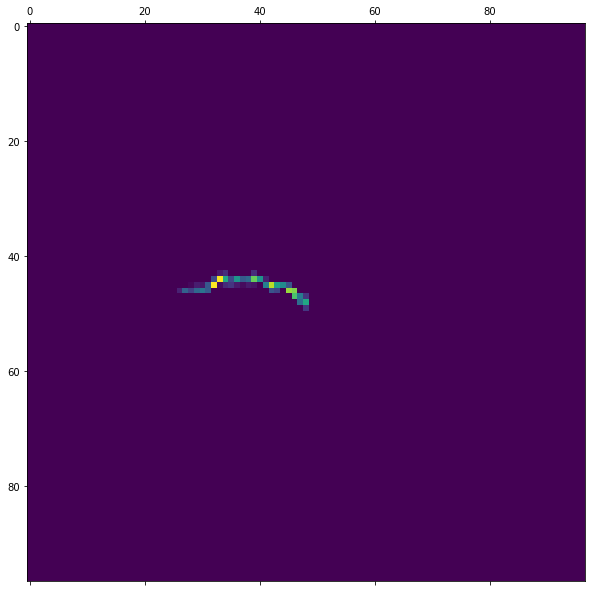

In [79]:
plt.figure(figsize=(10,10))
plt.matshow(F170_dat[20],fignum=1);

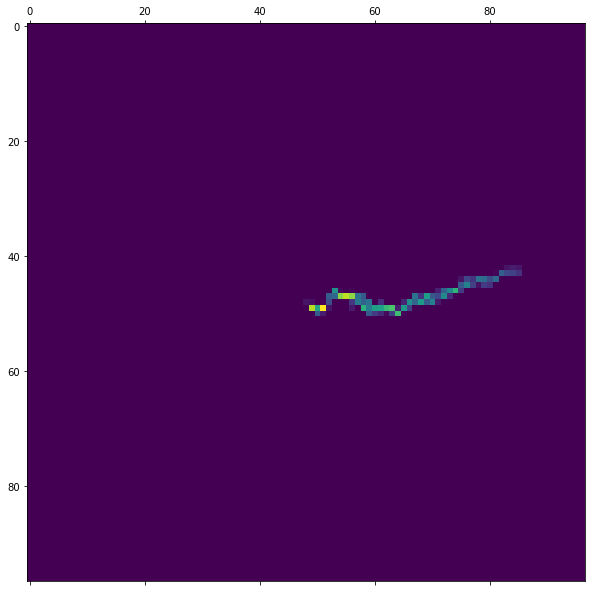

In [87]:
plt.figure(figsize=(10,10))
plt.matshow(C170_dat[17],fignum=1);

# New Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import sys
import random as rd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as tud
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import CustomDataset as cd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [2]:
C130_dat, F170_dat = np.load('data/C_130keV_1.npy'), np.load('data/F_170keV_1.npy')

In [3]:
np.shape(C130_dat)

(4000, 144, 144)

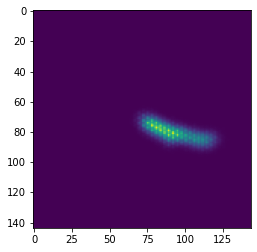

In [4]:
plt.imshow(C130_dat[100])

In [5]:
C130_dat = []

for i in range(10):
    data = np.load('data/C_130keV_'+str(i)+'.npy')
    for k in range(len(data)):
        C130_dat.append(data[k])

In [6]:
np.shape(C130_dat)

(40000, 144, 144)

In [7]:
F170_dat = []

for i in range(10):
    data = np.load('data/F_170keV_'+str(i)+'.npy')
    for k in range(len(data)):
        F170_dat.append(data[k])

In [8]:
np.shape(F170_dat)

(40000, 144, 144)

In [9]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))

In [10]:
data -= np.mean(data)
data/=np.std(data)

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

In [12]:
np.mean(train_data)

-3.555816147738405e-05

In [13]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(train_labels))
print(np.shape(test_labels))

(56000, 144, 144)
(24000, 144, 144)
(56000, 2)
(24000, 2)


In [14]:
dat_sum = [np.sum(test_data[i]) for i in range(len(test_data))]

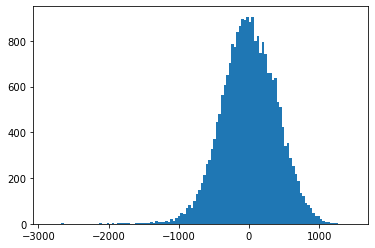

In [15]:
plt.hist(dat_sum,bins=120);

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(1, kernel_size=(3,3), input_shape=(144,144,1), activation='relu', padding='same'),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

2022-05-16 11:55:32.888886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 11:55:32.890646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vols/software/cuda/latest/CentOS7/lib64
2022-05-16 11:55:32.890676: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-16 11:55:32.891306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary i

In [17]:
model.summary()

Model: "nr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 1)       10        
                                                                 
 flatten (Flatten)           (None, 20736)             0         
                                                                 
 dense (Dense)               (None, 1024)              21234688  
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 21,236,748
Trainable params: 21,236,748
Non-trainable params: 0
_________________________________________________________________


In [18]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

2022-05-16 11:55:32.962931: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9289728000 exceeds 10% of free system memory.
2022-05-16 11:55:38.463720: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9289728000 exceeds 10% of free system memory.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(144, 144)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(144, 144)
(2,)


In [19]:
#batching the datasets
batch_size = 50
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [20]:
#compiling and fitting the model
sgd = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

2022-05-16 11:55:40.870766: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9289728000 exceeds 10% of free system memory.
2022-05-16 11:55:43.096892: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9289728000 exceeds 10% of free system memory.


Epoch 1/10
1120/1120 [==============================] - 58s 51ms/step - loss: 1.2495 - accuracy: 0.8165 - val_loss: 0.3497 - val_accuracy: 0.8523


2022-05-16 11:56:43.409733: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9289728000 exceeds 10% of free system memory.


Epoch 2/10
1120/1120 [==============================] - 57s 51ms/step - loss: 0.3288 - accuracy: 0.8626 - val_loss: 0.3295 - val_accuracy: 0.8651
Epoch 3/10
1120/1120 [==============================] - 57s 51ms/step - loss: 0.3098 - accuracy: 0.8711 - val_loss: 0.3112 - val_accuracy: 0.8739
Epoch 4/10
1120/1120 [==============================] - 57s 51ms/step - loss: 0.3044 - accuracy: 0.8730 - val_loss: 0.3144 - val_accuracy: 0.8708
Epoch 5/10
1120/1120 [==============================] - 57s 51ms/step - loss: 0.3002 - accuracy: 0.8746 - val_loss: 0.3224 - val_accuracy: 0.8620
Epoch 6/10
1120/1120 [==============================] - 58s 51ms/step - loss: 0.2974 - accuracy: 0.8754 - val_loss: 0.3270 - val_accuracy: 0.8669
Epoch 7/10
1120/1120 [==============================] - 57s 51ms/step - loss: 0.2971 - accuracy: 0.8750 - val_loss: 0.3711 - val_accuracy: 0.8511
Epoch 8/10
1120/1120 [==============================] - 57s 51ms/step - loss: 0.2937 - accuracy: 0.8777 - val_loss: 0.3425 -

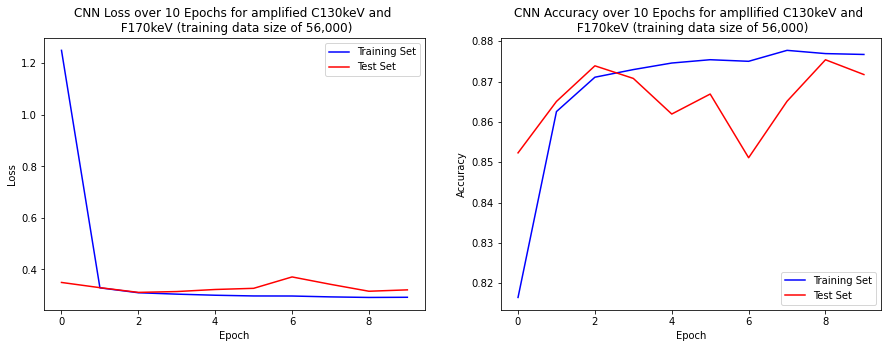

In [21]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss'],c='b'),ax1.plot(history.history['val_loss'],c='r')
ax1.set_title('CNN Loss over 10 Epochs for amplified C130keV and \n F170keV (training data size of 56,000)')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy'],c='b'),ax2.plot(history.history['val_accuracy'],c='r')
ax2.set_title('CNN Accuracy over 10 Epochs for ampllified C130keV and \n F170keV (training data size of 56,000)')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');